# Deep Learning &mdash; Assignment 11

Eleventh assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief and to the point, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational autoencoder
2. Extend the model to a conditional VAE

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch.

All libraries can be installed with `pip install`.

In [19]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from IPython import display

# Fix the seed to make the solutions more reproducible
torch.manual_seed(1);

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()
device = torch.device("cpu")

## 11.1 MNIST dataset (no points)

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes.

**(a) Run the code below to load the MNIST dataset.**

In [2]:
data_dir = 'data'
train_data = datasets.MNIST(data_dir, train=True,  download=True, transform=transforms.ToTensor())
test_data  = datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())

batch_size = 32
data_loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True),
    'val':   torch.utils.data.DataLoader(test_data,  batch_size=batch_size),
}
num_classes = 10

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:08<00:00, 1215921.37it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 264243.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1409653.26it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2213376.18it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 11.2 Variational Autoencoder (VAE) (3 points)

We will implement a Variational Autoencoder. This model consists of two networks: an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**(a) Complete the implementation below.<span style="float:right"> (2 points)</span>**

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)
        
        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: Choose an appropriate activation function for the final layer.
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        # TODO: turn the sample ε from N(0,1) into a sample from N(μ,σ)
        return eps*std_z + mean_z

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

In [4]:
# Here are some unit tests for the VAE
samples = VAE().sample_latent(torch.ones(10000), torch.ones(10000))
assert F.mse_loss(torch.mean(samples), torch.tensor(1.)) < 1e-3, \
      'sample_latent should produce values with the specified mean'
assert F.mse_loss(torch.log(torch.var(samples)), torch.tensor(1.)) < 1e-3, \
      'sample_latent should produce values with the specified log variance'

The encoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for doing it this way. 

**(b) What can go wrong if the encoder network directly outputs mean and standard deviation (μ,σ)?<span style="float:right"> (1 point)</span>**

By taking the logarithm, the gradients are smoothed and the optimization stabelized. If we were to optimize directly on, gradients grow linearly which could be critical for the stability of the optimization.

## 11.3 Loss function (2 points)

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = \log P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we can use [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf). Be careful:
* the paper defines $-D_{KL}$, not $D_{KL}$
* the sum is only over the latent space. In our code this corresponds to `axis=1`. Use the mean over the samples in the batch (`axis=0`).

**(a) Implement the KL loss term below.<span style="float:right"> (2 points)</span>**

In [10]:
def reconstruction_loss(recon_x, x):
    # The reconstruction loss is binary cross entropy
    # Note: we normalize the loss wrt. the batch size (len(x)), but not the size of the image
    return F.binary_cross_entropy(recon_x, x, reduction='sum') / len(x)

def kl_loss(mean_z, logvar_z):
    # The KL divergence between a standard normal distribution and
    #  a normal distribution with given mean and log-variance.
    # TODO: your code here
    # print(f"Shape of mean_z: {mean_z.shape}")
    # print(f"Shape of logvar_z: {logvar_z.shape}")
    logvar_z = logvar_z.float()
    mean_z = mean_z.float()
    logvar_z = torch.mean(logvar_z, dim=0)
    mean_z = torch.mean(mean_z, dim=0)
    kl_loss = -0.5 * torch.sum(1 +  logvar_z - mean_z.pow(2) - logvar_z.exp())
    return kl_loss

def loss_function(recon_x, x, mean_z, logvar_z):
    l_recon = reconstruction_loss(recon_x, x)
    l_kl    = kl_loss(mean_z, logvar_z)
    return l_recon + l_kl, l_recon, l_kl

In [11]:
# Here are some unit tests for the loss function
assert kl_loss(torch.tensor([[0]]), torch.tensor([[0]])) == 0, \
      'KL loss should be 0 for μ=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[-1]])) > 0, \
      'KL loss should be > 0 for μ=0, σ<1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) > 0, \
      'KL loss should be > 0 for μ=0, σ>1'
assert kl_loss(torch.tensor([[1]]), torch.tensor([[0]])) > 0, \
      'KL loss should be > 0 for μ!=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) == \
       kl_loss(torch.tensor([[0,0]]), torch.tensor([[1,1]])) / 2, \
      'Take the sum over the latent dimensions'
assert kl_loss(torch.tensor([[0,0,1]]), torch.tensor([[0,1,-0.5]])) == \
       kl_loss(torch.tensor([[0,0,1],[0,0,1]]), torch.tensor([[0,1,-0.5],[0,1,-0.5]])), \
      'Take the mean over the items in the batch or normalize wrt. batch size (see also reconstruction_loss)'

## 11.4 Training our VAE (3 points)

**(a) Complete the training loop below<span style="float:right"> (2 points)</span>**

In [ ]:
def train(model, data_loaders, num_epochs=10, lr=1e-3):
    train_loader = data_loaders['train']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                      legend=['train loss', 'train recon. loss', 'train KL loss',
                              'val loss', 'val recon. loss', 'val KL loss'])
    for epoch in range(num_epochs):
        metric = Metrics(3)
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            y_hat, mean_z, logvar_z = model(x)
            loss, loss_recon, loss_kl = loss_function(y_hat, x, mean_z, logvar_z)
            # TODO: backpropagate and apply optimizer
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(len(x), loss.item(), loss_recon.item(), loss_kl.item())
        # Compute validation loss
        val_loss, val_loss_recon, val_loss_kl = evaluate(model, data_loaders['val'], device=device)
        # Plot
        train_loss, train_loss_recon, train_loss_kl = metric.mean()
        plotter.add(epoch + 1,
                    (train_loss, train_loss_recon, train_loss_kl,
                     val_loss, val_loss_recon, val_loss_kl))
    print(f'training loss {train_loss:.3f}, val loss {val_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, val reconstruction loss {val_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, val KL loss {val_loss_kl:.3f}')

def evaluate(model, test_loader, device=device):
    """
    Evaluate a model on the given dataset.
    Return total loss, reconstruction loss, KL loss
    """
    with torch.no_grad():
        model.eval()
        metrics = Metrics(3)
        for x, _ in test_loader:
            x = x.to(device)
            # TODO: compute the outputs and loss
            y_hat, mean_z, logvar_z = model(x)
            loss, loss_recon, loss_kl = loss_function(y_hat, x, mean_z, logvar_z)
            metrics.add(len(x), loss.item(), loss_recon.item(), loss_kl.item())
        return metrics.mean()

class Metrics:
    """Accumulate mean values of one or more metrics."""
    def __init__(self, n):
        self.count = 0
        self.sum = (0,) * n
    def add(self, count, *values):
        self.count += count
        self.sum = tuple(s + count * v for s,v in zip(self.sum,values))
    def mean(self):
        return tuple(s / self.count for s in self.sum)

class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 nrows=1, ncols=1,
                 figsize=(10, 5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y = None, None

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y in zip(self.X, self.Y):
            self.axes[0].plot(x, y)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

**(b) Train the model.<span style="float:right"> (no points)</span>**

Hint: the training and test loss should both be around 160.

training loss 155.457, val loss 155.347
training reconstruction loss 151.265, val reconstruction loss 151.025
training KL loss 4.192, val KL loss 4.323


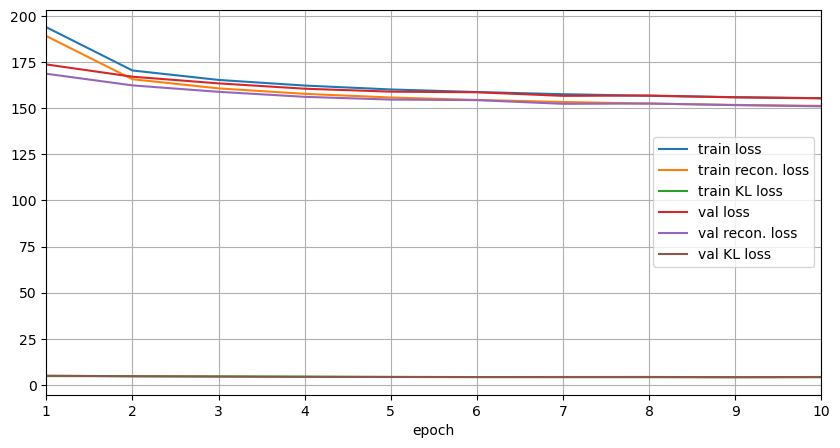

In [16]:
model = VAE().to(device)
train(model, data_loaders)

**(c) If you were to increase the number of latent dimensions, how would that affect the reconstruction loss and the KL loss terms?<span style="float:right"> (1 point)</span>**

Give an answer based on your theoretical understanding of VAEs, you don't have to actually do the experiment.

While a larger dimensionality in the latent space might improve the ability of the decoder to reconstruct the image (more complexity can be captured), it will most likely increase the KL loss as this extra flexibility in the latent space will allow the model so become overly specialized. This might deminish the generalisation performance and realism of new samples drawn from the prior distribution and processed by the decoder.

## 11.5 Visualizing the latent space (8 points)

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**(a) Complete the code below and run it to plot the latent space.<span style="float:right"> (1 point)</span>**

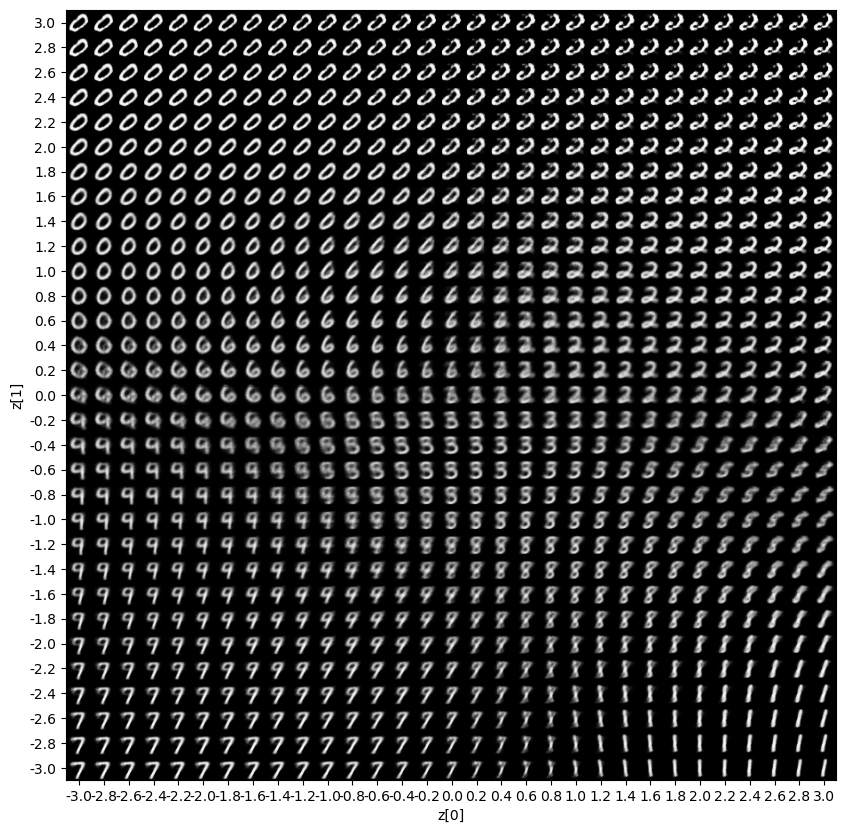

In [23]:
def plot_latent(model, bounds=3, n=31):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-bounds, bounds, n)
    grid_y = np.linspace(-bounds, bounds, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            x_decoded = model.decode(torch.tensor([[xi, yi]], dtype=torch.float32))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(model)

**(b) Would it be possible to use this latent representation to make a digit classifier? Explain your answer.<span style="float:right"> (1 point)</span>**

As there are distinct classes visible, extracting a new, labeled dataset from this latent space would in principle be possible and may be enough to train a classifier. Due to the high amount of structure, one might need to introduce more noise or resample data points. But it would probably be possible.

**(c) If you retrain the model, would you expect the latent space to look exactly the same. If not, what differences can you expect?<span style="float:right"> (1 point)</span>**

Neural networks are initialised randomly and the order in which samples are drawn form the training set also depends on chance. The latent space will therefore likely be different with a new run, but it will still follow the same principle and the same digits will be clustered together. So while the specific locations of clusters and the digit they correspond to may be different, the overall structure will remains consistent, but simply applying the same decoder won't guarantee good results.

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**(d) Complete and run the code below to make a scatterplot of the training data.<span style="float:right"> (1 point)</span>**

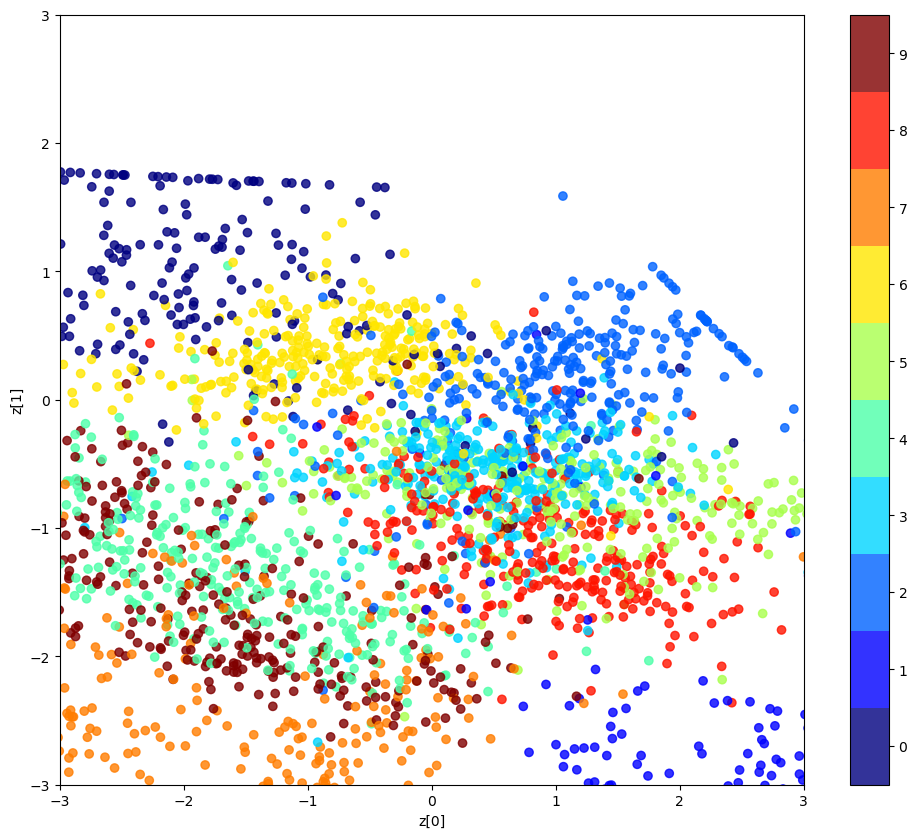

In [24]:
def scatterplot_latent(model, data_loader, bounds=3):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for x, y in itertools.islice(data_loader, 100):
        # TODO: compute mean z
        z_mean = model.encode(x.to(device))[0]
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-bounds, bounds)
    plt.ylim(-bounds, bounds)
    plt.show()

scatterplot_latent(model, data_loaders['train'])

**(e) Compare this figure to the one from `plot_latent`. How are the plots related?<span style="float:right"> (1 point)</span>**

Note: Don't just answer "both visualize the latent space"

Numbers that are adjacent in one of the plots are also adjacent in the other one; numbers that are clustered far apart will also be on opposing ends in the alternative visualisation. This consistency demonstrates that the latent space indeed meaningfully encodes the distances and relationships between different digits and their representation.

**(f) Compared to the figure from `plot_latent`, what information about the VAE is shown in this figure but not in the previous one?<span style="float:right"> (1 point)</span>**

The `plot_latent` does not give any information about the true label of the data points. In contrast, `scatterplot_latent` does show this information. Like this, it is visible how wide the points in one class are spread or how much they overlap.

**(g) What distribution should we expect the points in the latent space to follow, based on the KL divergence term in the loss function?<span style="float:right"> (1 point)</span>**

As the KL loss punishes the model for having a large deviation between the distribution in the latent space and the prior distribution, we expect the distribution of the latent space to align with the normal prior distribution.

**(h) Look at the distribution of the data in the latent space. Does the plot match the answer to the previous question? If not, why?<span style="float:right"> (1 point)</span>**

The plot does not exactly show a normal distribution in the latent space. As the model has to balance the KL loss with the reconstruciton loss, it also needs to optimize data-specific encoding. If the KL loss was weighted more heavily, this would probably be the case.

## 11.6 Conditional Variational Autoencoder (10 points)

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this *conditional VAE*, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice, this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z \cdot z + W_y \cdot y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**(a) Complete the implementation of the conditional VAE below.<span style="float:right"> (3 points)</span>**

In [26]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input
        self.encoder_part1_x = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
        )
        self.encoder_part1_y = nn.Sequential(
            nn.Linear(num_classes, 32 * 14 * 14)
        )
        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # TODO: add layer to use with the y input
        self.decoder_part1_y = nn.Sequential(
            nn.Linear(num_classes, 7 * 7 * 64)
        )
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
            nn.Sigmoid()
        )

    def encode(self, x, y):
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        # TODO: see VAE
        return eps * std_z + mean_z  # Reparameterization trick

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        h = self.decoder_part1_z(z) + self.decoder_part1_y(y)
        h = torch.reshape(h, (-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**(b) Copy the training code from section 11.4, and modify it for a conditional VAE.<span style="float:right"> (1 point)</span>**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [31]:
def train_cvae(model, data_loaders, num_epochs=10, lr=1e-3, device=device):
    # TODO: your code here
    train_loader = data_loaders['train']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                      legend=['train loss', 'train recon. loss', 'train KL loss',
                              'val loss', 'val recon. loss', 'val KL loss'])
    for epoch in range(num_epochs):
        metric = Metrics(3)
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = F.one_hot(y,10).float().to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            y_hat, mean_z, logvar_z = model(x, y)
            loss, loss_recon, loss_kl = loss_function(y_hat, x, mean_z, logvar_z)
            # TODO: backpropagate and apply optimizer
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(len(x), loss.item(), loss_recon.item(), loss_kl.item())
        # Compute validation loss
        val_loss, val_loss_recon, val_loss_kl = evaluate_cvae(model, data_loaders['val'], device=device)
        # Plot
        train_loss, train_loss_recon, train_loss_kl = metric.mean()
        plotter.add(epoch + 1,
                    (train_loss, train_loss_recon, train_loss_kl,
                     val_loss, val_loss_recon, val_loss_kl))
    print(f'training loss {train_loss:.3f}, val loss {val_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, val reconstruction loss {val_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, val KL loss {val_loss_kl:.3f}')
    

def evaluate_cvae(model, test_loader, device=device):
    """
    Evaluate a conditional model on the given dataset.
    Return total loss, reconstruction loss, KL loss
    """
    # TODO: your code here
    with torch.no_grad():
        model.eval()
        metrics = Metrics(3)
        for x, y in test_loader:
            x = x.to(device)
            y = F.one_hot(y,10).float().to(device)
            y_hat, mean_z, logvar_z = model(x, y)
            loss, loss_recon, loss_kl = loss_function(y_hat, x, mean_z, logvar_z)
            metrics.add(len(x), loss.item(), loss_recon.item(), loss_kl.item())
        return metrics.mean()

**(c) Train a conditional VAE**

training loss 129.778, val loss 130.866
training reconstruction loss 126.757, val reconstruction loss 126.967
training KL loss 3.021, val KL loss 3.899


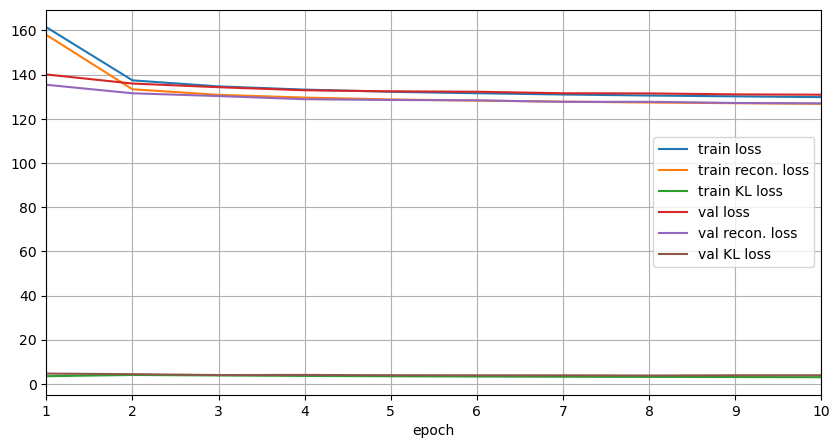

In [32]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model, data_loaders)

**(d) Adapt the `plot_latent` function from section 11.5 for conditional VAEs, and use your function to visualize the latent space for the classes `4` and `8`.<span style="float:right"> (1 point)</span>**

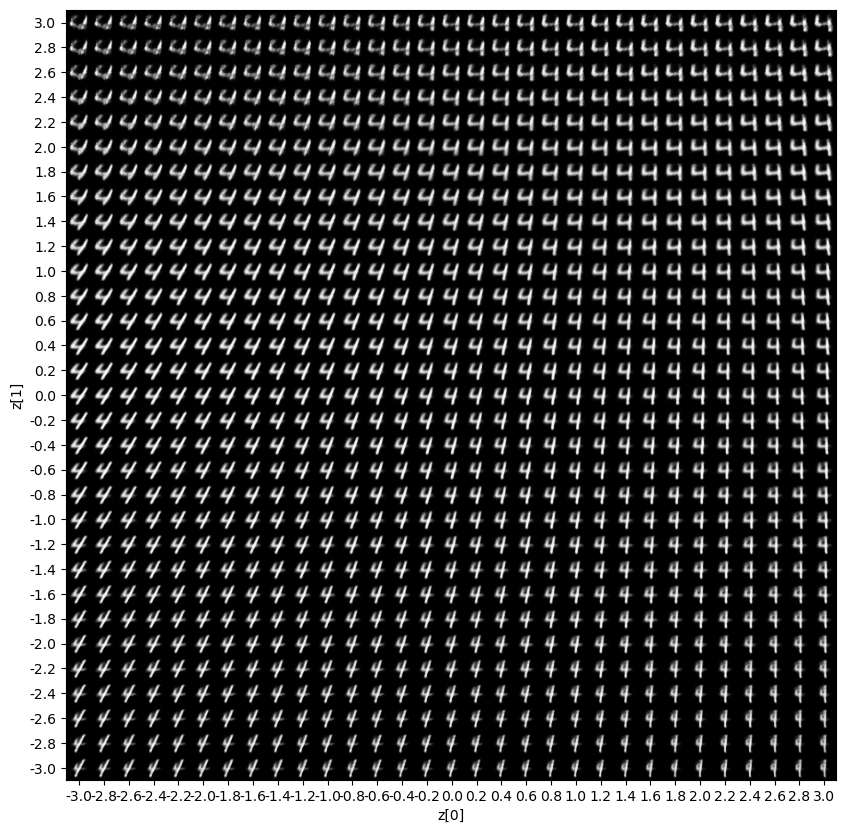

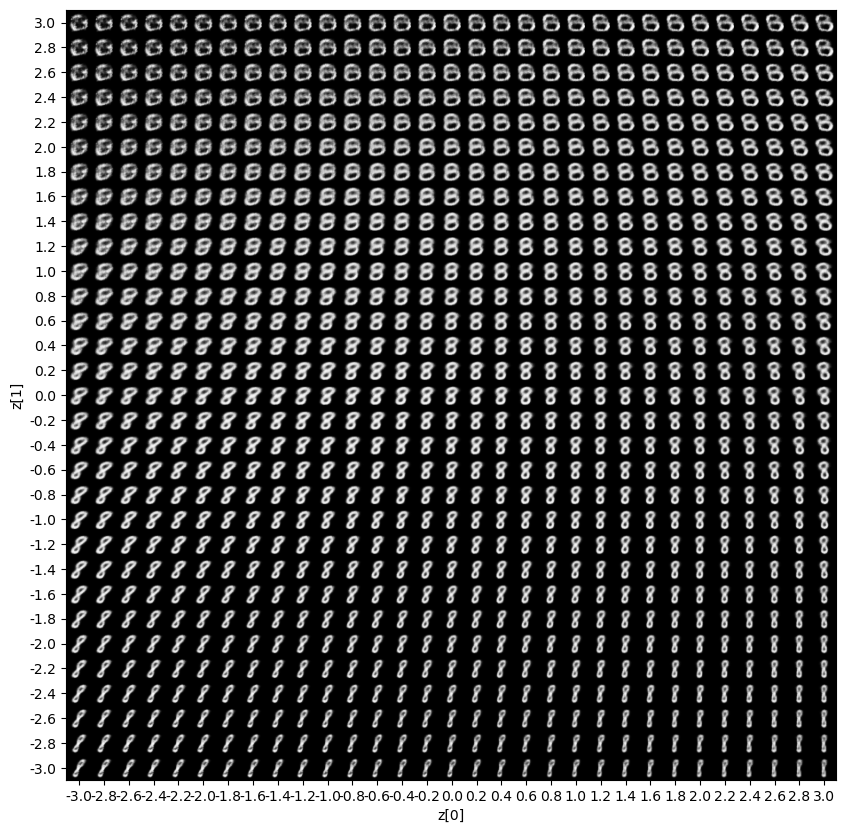

In [40]:
def plot_latent_cvae(model, class_nr: int, bounds=3, n=31):
    # display a n*n 2D manifold of digits
    y = F.one_hot(torch.tensor([class_nr]),10).float().to(device)
    digit_size = 28
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-bounds, bounds, n)
    grid_y = np.linspace(-bounds, bounds, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            x_decoded = model.decode(torch.tensor([[xi, yi]], dtype=torch.float32), y)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_cvae(cvae_model, 4)
plot_latent_cvae(cvae_model, 8)

**(e) What do the latent dimensions represent? Is this the same for all labels?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(f) Adapt `scatterplot_latent` to show the distribution in the latent space.<span style="float:right"> (1 point)</span>**

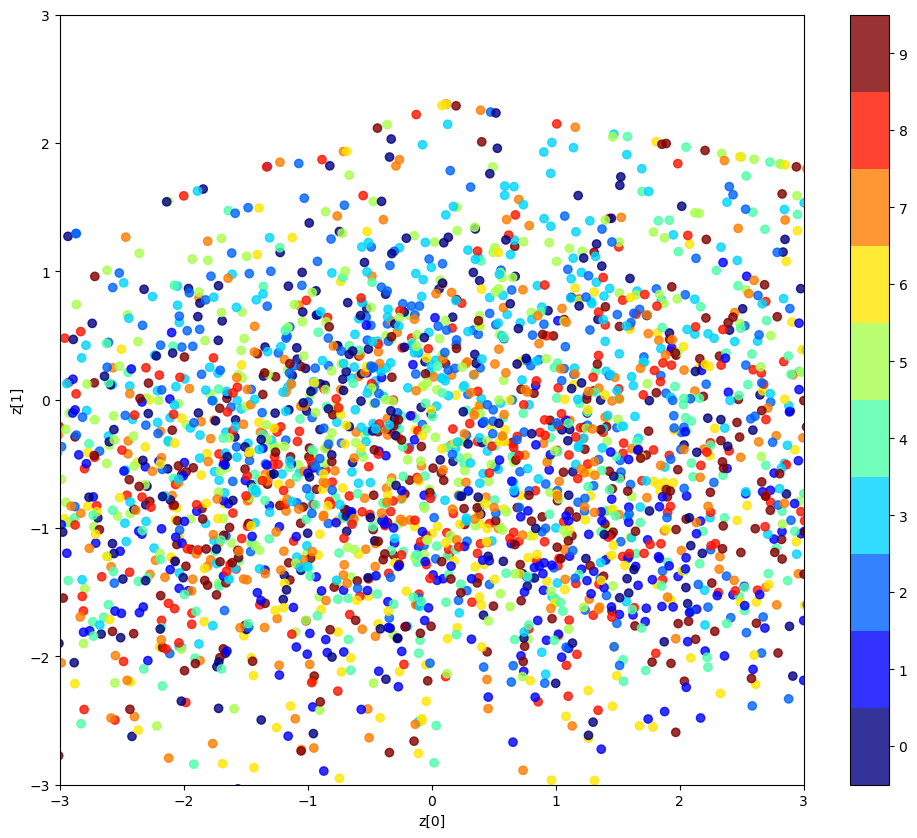

In [ ]:
def scatterplot_latent_cvae(model, data_loader, bounds=3):
    zs, ys = [], []
    for x, y in itertools.islice(data_loader, 100):
        x_model = x.to(device)
        y_model = F.one_hot(y,10).float().to(device)
        z_mean = model.encode(x_model, y_model)[0]
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-bounds, bounds)
    plt.ylim(-bounds, bounds)
    plt.show()

scatterplot_latent_cvae(cvae_model, data_loaders['train'])

**(g) How is this distribution in the latent space different from the distribution of the VAE? Compare to your answer to that for question 11.5 g and h. What is the cause of these differences?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(h) Would it be possible to classify digits based on the latent representation of the conditional VAE? Explain your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(i) Describe how you could use a conditional VAE to change the label or content of an image, while keeping the style as similar as possible.<span style="float:right"> (1 point)</span>**

TODO: your answer here

## 11.7 Discussion (3 points)

**(a) Is the conditional VAE a strict improvement over the normal VAE in all cases?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(b) Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. They are both small vectors, and they are both often called $z$. In what way are they the same, and in what way are the different?<span class="float:right"> (1 point)</span>**

TODO: your answer here

**(c) A VAE and a normalizing flow mode both allow you to transform between the data space and a latent space, and in both models the latent space has a standard normal distribution. Yet there are some differences. Give 2 differences between VAE and NF models.<span class="float:right"> (1 point)</span>**

TODO: your answer here

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 29 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version b117570 / 2024-11-25</span>